In [25]:

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# générer les données
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=5,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    weights=None,
    flip_y=0.01,
    class_sep=1.0,
    random_state=42,
)

# mettre dans des DataFrame pour la lisibilité
feature_names = [f"f{i}" for i in range(X.shape[1])]
df_X = pd.DataFrame(X, columns=feature_names)
df_y = pd.Series(y, name="target")

In [27]:
# split train / test (stratifié pour garder la proportion de classes)
X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_y, test_size=0.2, stratify=df_y, random_state=42
)

In [28]:
# Standardisation (mean=0, std=1) — généralement bon pour les réseaux de neurones
scaler_std = StandardScaler()
X_train_std = pd.DataFrame(scaler_std.fit_transform(X_train), columns=feature_names, index=X_train.index)
X_test_std = pd.DataFrame(scaler_std.transform(X_test), columns=feature_names, index=X_test.index)

# vérifications rapides
print("Shapes:", X_train.shape, X_test.shape)
print("Standardized train mean (approx):\n", X_train_std.mean().round(3).head())
print("Standardized train std (approx):\n", X_train_std.std().round(3).head())
print("\nExemple (standardisé) :")
print(X_train_std.head())

Shapes: (800, 20) (200, 20)
Standardized train mean (approx):
 f0    0.0
f1   -0.0
f2   -0.0
f3    0.0
f4    0.0
dtype: float64
Standardized train std (approx):
 f0    1.001
f1    1.001
f2    1.001
f3    1.001
f4    1.001
dtype: float64

Exemple (standardisé) :
           f0        f1        f2        f3        f4        f5        f6  \
267  1.382846  0.493130 -0.078681  1.147121  2.920376 -0.914853 -0.857130   
914  1.538441 -0.645409  0.446986 -0.735868 -1.516638 -0.319762  2.224777   
2    1.766145  0.219869 -0.344792 -0.856202  1.089023  0.269610  1.317439   
597  0.639404  0.745321  2.169726  0.513303  0.408885  0.833700  1.200136   
291 -1.223367 -1.713819 -0.226792  0.090346 -0.770296 -0.967817 -1.106218   

           f7        f8        f9       f10       f11       f12       f13  \
267 -0.678847  0.673634 -0.328998 -0.886797  0.792117  0.551922  0.896100   
914  0.461804  0.947195  1.218816 -2.012680 -0.250149 -0.374210  2.737886   
2    0.503595  0.006628  0.955494 -1.241698 

In [29]:
# préparer les données (utiliser les versions standardisées)
X_tr = X_train_std.values
X_te = X_test_std.values
y_tr = y_train.values
y_te = y_test.values

input_dim = X_tr.shape[1]

# modèle profond simple
model = Sequential([
    Dense(128, activation="relu", input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1, activation="sigmoid")
])

# compilation du modèle : perte binaire, optimiseur Adam, métriques accuracy + AUC
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)

model.summary()


/home/codenam/Github/ml-exercises/algorithm-exercises/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,953 (54.50 KB)

 Trainable params: 13,505 (52.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [30]:

# callbacks
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# entraînement
history = model.fit(
    X_tr, y_tr,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

Epoch 1/100
20/20 - 3s - 138ms/step - AUC: 0.6127 - accuracy: 0.5938 - loss: 0.7609 - val_AUC: 0.7733 - val_accuracy: 0.6812 - val_loss: 0.6255
Epoch 2/100
20/20 - 0s - 7ms/step - AUC: 0.7701 - accuracy: 0.6828 - loss: 0.5719 - val_AUC: 0.8426 - val_accuracy: 0.7937 - val_loss: 0.5784
Epoch 3/100
20/20 - 0s - 7ms/step - AUC: 0.8328 - accuracy: 0.7656 - loss: 0.5055 - val_AUC: 0.8742 - val_accuracy: 0.8000 - val_loss: 0.5342
Epoch 4/100
20/20 - 0s - 6ms/step - AUC: 0.8878 - accuracy: 0.8031 - loss: 0.4238 - val_AUC: 0.8835 - val_accuracy: 0.7875 - val_loss: 0.4986
Epoch 5/100
20/20 - 0s - 6ms/step - AUC: 0.8915 - accuracy: 0.7984 - loss: 0.4183 - val_AUC: 0.9016 - val_accuracy: 0.8313 - val_loss: 0.4598
Epoch 6/100
20/20 - 0s - 8ms/step - AUC: 0.9181 - accuracy: 0.8359 - loss: 0.3633 - val_AUC: 0.9074 - val_accuracy: 0.8438 - val_loss: 0.4288
Epoch 7/100
20/20 - 0s - 8ms/step - AUC: 0.9355 - accuracy: 0.8609 - loss: 0.3306 - val_AUC: 0.9138 - val_accuracy: 0.8313 - val_loss: 0.4020
Epoc

In [31]:
# évaluation
evaluation_results = model.evaluate(X_te, y_te, verbose=0)

# normaliser les types et extraire loss / acc (si présents)
if isinstance(evaluation_results, (list, tuple)):
    eval_vals = [float(v) for v in evaluation_results]
    loss = eval_vals[0]
    acc = eval_vals[1] if len(eval_vals) > 1 else None
else:
    loss = float(evaluation_results)
    acc = None

y_pred_proba = model.predict(X_te).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


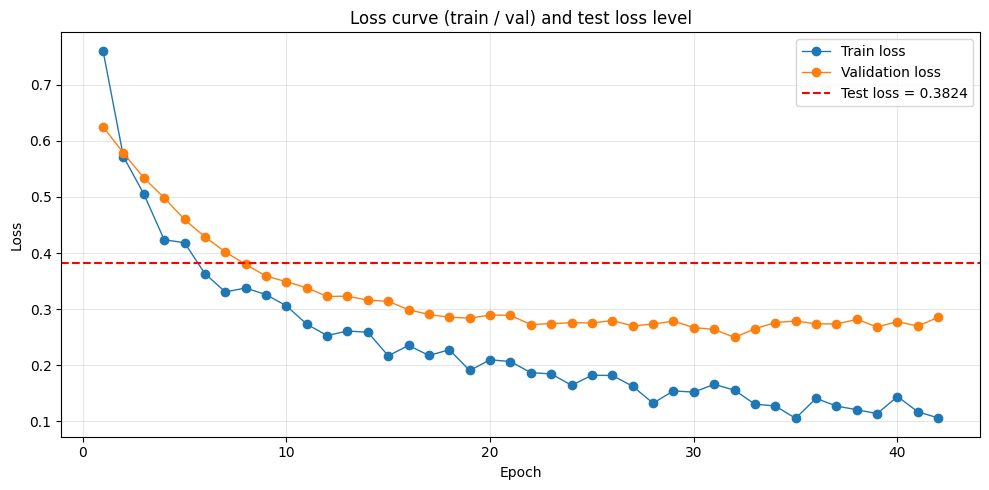

In [32]:
fig = plt.figure(constrained_layout=False, figsize=(10, 5))
ax_loss = fig.add_subplot(1, 1, 1)

# récupérer l'historique en toute sécurité
hist = history.history if hasattr(history, "history") else history
train_loss = hist.get("loss", [])
val_loss = hist.get("val_loss", [])

# epochs (protéger si train_loss vide)
epochs = range(1, max(1, len(train_loss)) + 1)

# tracer
if train_loss:
    ax_loss.plot(epochs[: len(train_loss)], train_loss, label="Train loss", marker="o", linewidth=1)
if val_loss:
    ax_loss.plot(epochs[: len(val_loss)], val_loss, label="Validation loss", marker="o", linewidth=1)

# ligne horizontale pour test loss (si définie)
try:
    ax_loss.axhline(loss, color="red", linestyle="--", linewidth=1.5, label=f"Test loss = {loss:.4f}")
except NameError:
    # loss non défini : ne pas tracer la ligne
    pass

ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.set_title("Loss curve (train / val) and test loss level")
ax_loss.legend()
ax_loss.grid(alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipykernel_106045/386939410.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


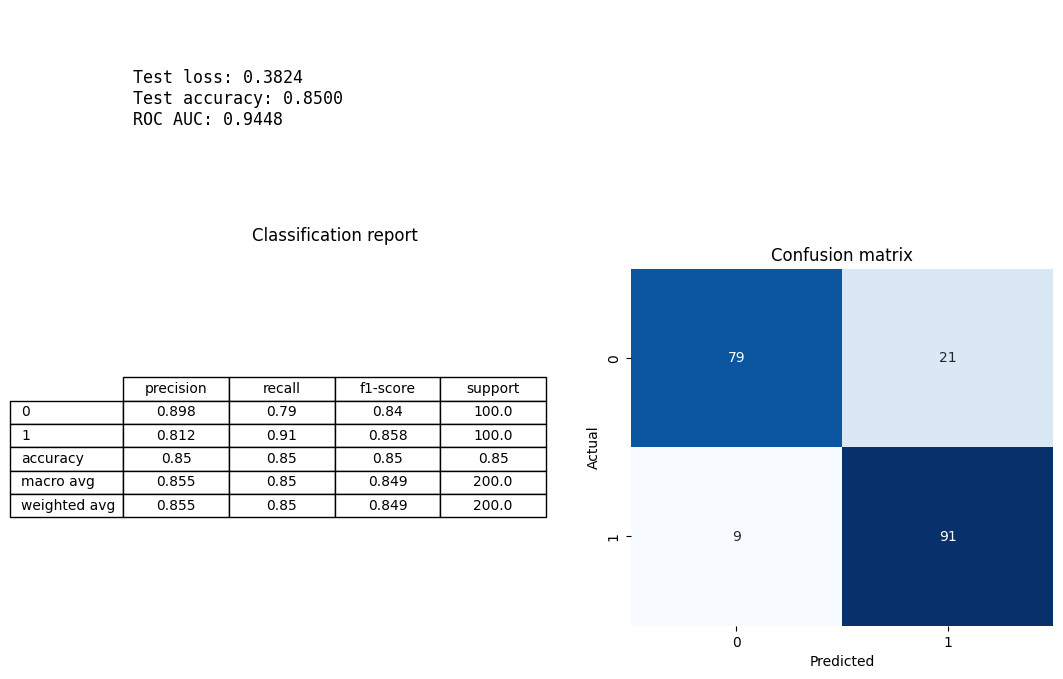

In [33]:
# loss, acc, roc, y_te, y_pred, y_pred_proba

# obtenir le classification report sous forme de DataFrame
cr_dict = classification_report(y_te, y_pred, output_dict=True)
cr_df = pd.DataFrame(cr_dict).transpose().round(3)

# matrice de confusion
cm = confusion_matrix(y_te, y_pred)

# dessin
fig = plt.figure(constrained_layout=False, figsize=(12, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[0.8, 1.6], width_ratios=[1,1], hspace=0.3)

ax_title = fig.add_subplot(gs[0, :])
ax_table = fig.add_subplot(gs[1, 0])
ax_cm = fig.add_subplot(gs[1, 1])

# zone titre / metrics
ax_title.axis("off")
metrics_text = f"Test loss: {loss:.4f}\n"
if acc is not None:
    metrics_text += f"Test accuracy: {acc:.4f}\n"
metrics_text += f"ROC AUC: {roc:.4f}"
ax_title.text(0.01, 0.5, metrics_text, fontsize=12, va="center", family="monospace")

# classification report comme tableau
ax_table.axis("off")
table = ax_table.table(
    cellText=cr_df.values,
    rowLabels=cr_df.index,
    colLabels=cr_df.columns,
    cellLoc="center",
    loc="center"
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.4)
ax_table.set_title("Classification report", pad=20)

# heatmap de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax_cm)
ax_cm.set_xlabel("Predicted")
ax_cm.set_ylabel("Actual")
ax_cm.set_title("Confusion matrix")

plt.tight_layout()
plt.show()